<a href="https://colab.research.google.com/github/BrenyQT/CS4287-Atari/blob/main/CS4287_Prj2_21315205_21318174_21307571.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Brendan Quinn: 21315205
Kevin Hough: 21307571
Sophie Quinn: 21318174

2. The code excecutes without error

3. Resources:
      - Adam Optimiser: https://keras.io/api/optimizers/adam/
      - Gymnasium: https://gymnasium.farama.org

# 1. **Why Reinforcement Learning is the machine learning paradigm of choice for this task:**

Reinforcement Learning is suitable for solving Atari Pong because:

 **Sequential Decision Making:** Pong involves moving a paddle up and down to hit aball back toward an opponent. This means a decision needs to be made at each time step. The agents goal is to maximise the games score by leatrning an optimal sequence of movements. Reinforcement Learning allows for solving problems where the current decision impacts future rewards.

**Dynamic and Interactive Learning Environment:** Pong is an interactive game where the balls position and direction are directly influenced bt the agents actions and the opponents behaviour. Reinforcemeent Learning adapts to the eveolving enviroment by learning through interaction.

**Reward Driven Learning:** The reward signal in pong is straightforward. A postive reward is given for scoring a point. A negative reward is given for coding a point. Reinforcement Learning is designed to optimize cumulative rewards. This makes it well suited for tasks with such clearly defined goals.

# 2. **The Gym Environment:**
 The Gym Enviroment was developled by Open AI in 2016. The Gym Enviroment is a widely used API for developing and eveluating Reinforcement Learning algorithms. It provides a standerdized interface and a diverse set of enviroments, including classic control tasks, board games and Atari games. This standeardization provides a benchmarking enviroment where several Reinforcemnt Learning algorithms can be tested.

**Standerdized Interface:** Gym provides an API for interacting with various enviroments. This median of stardardization allows researchers to apply their Reinforcement Learning algorithms accross different tasks without significant change.

**Predefined Enviroments:** Gym includes a collection of predefined enviroments such as **'Pong-v5'**. These enviroments come with a predefined state and action spaces, reward structures and dynamics. This allows researchers to focus on algorithm developments rather than enviroment creation.

**Visualization Tools:** Gym provides rendering capbilities to visualize the agents interaction with the enviroment. This aid the debugging process.

By utilizing the Gym Enviroment we can leverage  a standardized platform to develop, test and benchmark our Reinforcement Learing Algorithm effectively.

https://cse.sc.edu/~aakriti/aakriti_files/RL_Pong_Final.pdf



# 3. **Implementation:**


In [ ]:

!pip install tensorflow opencv-python matplotlib numpy
!pip install gymnasium[atari] autorom[accept-rom-license] ale-py tqdm
!AutoROM --accept-license
!pip install ale-py tqdm

import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import random
from collections import deque
import cv2
import matplotlib.pyplot as plt
import gymnasium as gym
import ale_py
import matplotlib.animation as animation
from IPython.display import HTML

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 29.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.1 MB/s eta 0:00:00
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 56.9 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446667 sha256=396f50b256bf3cb9b65b5d2f8617258cd4a45205415144586bb473a9474b0184
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.10/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


**A. Capture and pre-processing of the data (3 marks).**

In [ ]:
# Frame Preprocessing
def preprocess_frame(frame):
    """
    Converts an input frame to grayscale, resizes to 84x84, and normalizes pixel values.
    """
    if frame.ndim == 3 and frame.shape[2] == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    frame = cv2.resize(frame, (84, 84))  # Resize to 84x84
    return frame / 255.0  # Normalize pixel values to [0, 1]

# Stack Frames for Temporal Information
def stack_frames(stack, new_frame, stack_size=4):
    """
    Stacks the current frame with the previous frames to create temporal information.
    """
    if stack is None:
        # Initialize stack with repeated frames
        stack = np.stack([new_frame for _ in range(stack_size)], axis=-1)
    else:
        # Remove the oldest frame and add the new frame
        stack = np.concatenate((stack[..., 1:], np.expand_dims(new_frame, axis=-1)), axis=-1)
    return stack


In [ ]:
def build_dqn(input_shape, action_space):
    model = models.Sequential([
        layers.Conv2D(32, (8, 8), strides=4, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (4, 4), strides=2, activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), strides=1, activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(action_space, activation='linear')  # Output Q-values
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss='mse')
    return model



In [ ]:
# DQN Agent Class
class DQNAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.memory = deque(maxlen=200000)  # Increase buffer size
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_min = 0.05   # Minimum exploration rate
        self.epsilon_decay = 0.985  # Decay faster
        self.batch_size = 64  # Batch size for training
        self.model = build_dqn((84, 84, 4), action_space)  # Online model
        self.target_model = build_dqn((84, 84, 4), action_space)  # Target model
        self.update_target_model()

    def update_target_model(self):
        """
        Copies weights from the online model to the target model.
        """
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Stores a transition in the replay buffer.
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Chooses an action based on an epsilon-greedy policy.
        """
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_space)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self):

      if len(self.memory) < self.batch_size:
            return

      batch = random.sample(self.memory, self.batch_size)
      states, targets = [], []

      for state, action, reward, next_state, done in batch:
            target = self.model.predict(state, verbose=0)[0]
            if done:
                target[action] = reward
            else:
                t = self.target_model.predict(next_state, verbose=0)[0]
                target[action] = reward + self.gamma * np.max(t)

            states.append(state[0])
            targets.append(target)

      self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0, batch_size=self.batch_size)

        # Decay epsilon
      if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

            #So i want it to start doing random shit, and then when it hits the end need it to choose randomly not as much

In [ ]:
# Initialize Environment
env = gym.make('ALE/Pong-v5')
agent = DQNAgent(action_space=env.action_space.n)

episodes = 300
rewards = []
mean_rewards = []
stack_size = 4

for episode in range(episodes):
    state, info = env.reset()
    state = preprocess_frame(state)
    state_stack = stack_frames(None, state, stack_size)
    state_stack = np.expand_dims(state_stack, axis=0)

    frames = []
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state_stack)
        next_state, reward, done, truncated, info = env.step(action)

        if reward > 0:  # Winning a point
            reward += 30  # Big reward for scoring
        elif reward < 0:  # Losing a point
            reward -= -40  # Strong penalty for losing
        else:  # Small incentive for keeping the ball in play
            reward = 5

        total_reward += reward
        if done or truncated:
            break

        next_state = preprocess_frame(next_state)
        next_state_stack = stack_frames(state_stack[0], next_state, stack_size)
        next_state_stack = np.expand_dims(next_state_stack, axis=0)

        agent.remember(state_stack, action, reward, next_state_stack, done)
        state_stack = next_state_stack

    # Replay and update target network
    agent.replay()
    if episode == 150:
      agent.epsilon == 0.4
    if episode == 250:
      agent.epsilon = 0.2

    if episode % 10 == 0:
        agent.update_target_model()

    rewards.append(total_reward)
    mean_rewards.append(np.mean(rewards[-10:]))
    print(f"Episode: {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

# Plot rewards to show progress


plt.plot(rewards)
plt.plot(mean_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title("Learning Progress Over Episodes (Original DQN)")
plt.show()

# Save model weights for future use
agent.model.save('pong_original_dqn_300_episodes.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1/300, Total Reward: 5434.0, Epsilon: 0.98
Episode: 2/300, Total Reward: 5686.0, Epsilon: 0.97
Episode: 3/300, Total Reward: 4534.0, Epsilon: 0.96
Episode: 4/300, Total Reward: 5365.0, Epsilon: 0.94
Episode: 5/300, Total Reward: 5250.0, Epsilon: 0.93
Episode: 6/300, Total Reward: 4534.0, Epsilon: 0.91
Episode: 7/300, Total Reward: 4674.0, Epsilon: 0.90
Episode: 8/300, Total Reward: 4534.0, Epsilon: 0.89
Episode: 9/300, Total Reward: 6024.0, Epsilon: 0.87
Episode: 10/300, Total Reward: 4534.0, Epsilon: 0.86
Episode: 11/300, Total Reward: 4534.0, Epsilon: 0.85
Episode: 12/300, Total Reward: 4534.0, Epsilon: 0.83
Episode: 13/300, Total Reward: 5351.0, Epsilon: 0.82
Episode: 14/300, Total Reward: 4534.0, Epsilon: 0.81
Episode: 15/300, Total Reward: 4534.0, Epsilon: 0.80
Episode: 16/300, Total Reward: 4534.0, Epsilon: 0.79
Episode: 17/300, Total Reward: 4534.0, Epsilon: 0.77
Episode: 18/300, Total Reward: 5144.0, Epsilon: 0.76
Episode: 19/300, Total Reward: 4534.0, Epsilon: 0.75
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1/300, Total Reward: 5434.0, Epsilon: 0.98
Episode: 2/300, Total Reward: 5686.0, Epsilon: 0.97
Episode: 3/300, Total Reward: 4534.0, Epsilon: 0.96
Episode: 4/300, Total Reward: 5365.0, Epsilon: 0.94
Episode: 5/300, Total Reward: 5250.0, Epsilon: 0.93
Episode: 6/300, Total Reward: 4534.0, Epsilon: 0.91
Episode: 7/300, Total Reward: 4674.0, Epsilon: 0.90
Episode: 8/300, Total Reward: 4534.0, Epsilon: 0.89
Episode: 9/300, Total Reward: 6024.0, Epsilon: 0.87
Episode: 10/300, Total Reward: 4534.0, Epsilon: 0.86
Episode: 11/300, Total Reward: 4534.0, Epsilon: 0.85
Episode: 12/300, Total Reward: 4534.0, Epsilon: 0.83
Episode: 13/300, Total Reward: 5351.0, Epsilon: 0.82
Episode: 14/300, Total Reward: 4534.0, Epsilon: 0.81
Episode: 15/300, Total Reward: 4534.0, Epsilon: 0.80
Episode: 16/300, Total Reward: 4534.0, Epsilon: 0.79
Episode: 17/300, Total Reward: 4534.0, Epsilon: 0.77
Episode: 18/300, Total Reward: 5144.0, Epsilon: 0.76
Episode: 19/300, Total Reward: 4534.0, Epsilon: 0.75
Ep

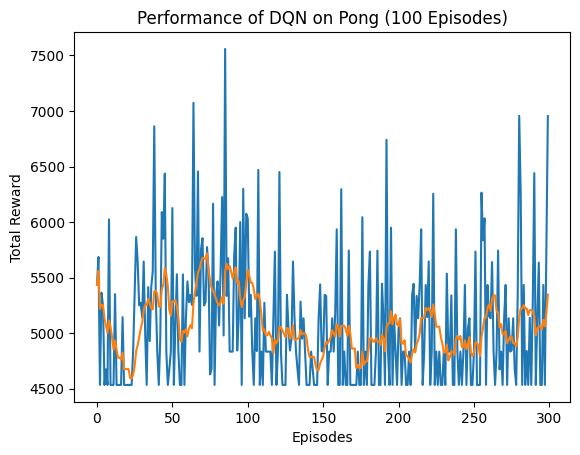

In [ ]:
  # Initialize Environment
env = gym.make('ALE/Pong-v5')
agent = DQNAgent(action_space=env.action_space.n)

episodes = 300
rewards = []
mean_rewards = []
stack_size = 4

for episode in range(episodes):
    state, info = env.reset()
    state = preprocess_frame(state)
    state_stack = stack_frames(None, state, stack_size)
    state_stack = np.expand_dims(state_stack, axis=0)

    frames = []
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state_stack)
        next_state, reward, done, truncated, info = env.step(action)

        if reward > 0:  # Winning a point
            reward += 30  # Big reward for scoring
        elif reward < 0:  # Losing a point
            reward -= -40  # Strong penalty for losing
        else:  # Small incentive for keeping the ball in play
            reward = 5

        total_reward += reward
        if done or truncated:
            break

        next_state = preprocess_frame(next_state)
        next_state_stack = stack_frames(state_stack[0], next_state, stack_size)
        next_state_stack = np.expand_dims(next_state_stack, axis=0)

        agent.remember(state_stack, action, reward, next_state_stack, done)
        state_stack = next_state_stack

    # Replay and update target network
    agent.replay()
    if episode == 150:
      agent.epsilon = 0.4
    if episode == 250:
      agent.epsilon = 0.2

    if episode % 10 == 0:
        agent.update_target_model()

    rewards.append(total_reward)
    mean_rewards.append(np.mean(rewards[-10:]))
    print(f"Episode: {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

# Plot rewards to show progress


plt.plot(rewards)
plt.plot(mean_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Performance of DQN on Pong (100 Episodes)')
plt.show()

# Save model weights for future use
agent.model.save('pong_dqn_100_episodes.h5')


# **Optimised Implimentation**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda  # Import Lambda layer


def preprocess_frame_optimized(frame):
    if len(frame.shape) == 3:  # RGB image
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)  # Resize
    if frame.shape != (84, 84):
        raise ValueError(f"Preprocessed frame shape mismatch. Expected (84, 84), got {frame.shape}")
    return frame / 255.0  # Normalize to [0, 1]

# Frame Stacking
def stack_frames_optimized(stack, frame, is_new_episode):
    frame = np.array(frame)
    if frame.shape != (84, 84):
        raise ValueError(f"Frame shape mismatch. Expected (84, 84), got {frame.shape}")

    if is_new_episode:
        # Start with a 4-frame stack, all initialized to the current frame
        stack = np.stack([frame] * 4, axis=-1)  # Shape will be (84, 84, 4)
    else:
        # Convert stack to a 3D array if needed
        stack = np.array(stack)
        if stack.ndim != 3 or stack.shape[:2] != (84, 84):
            raise ValueError(f"Stack shape mismatch. Expected (84, 84, 4), got {stack.shape}")

        # Remove the oldest frame and add the new frame
        stack = np.concatenate((stack[:, :, 1:], frame[:, :, np.newaxis]), axis=-1)

    # Validate the final stack shape
    if stack.shape != (84, 84, 4):
        raise ValueError(f"Final stack shape mismatch. Expected (84, 84, 4), got {stack.shape}")

    return stack, stack




In [ ]:
# Residual Block
def residual_block_optimized(x, filters, kernel_size, strides):
    shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same')(x)  # Match dimensions if needed
    x = layers.Conv2D(filters, kernel_size, strides=strides, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, activation=None, padding='same')(x)
    x = layers.Add()([x, shortcut])  # Residual connection
    x = layers.Activation('relu')(x)
    return x

# Noisy Dense Layer
class NoisyDenseOptimized(layers.Layer):
    def __init__(self, units, **kwargs):
        super(NoisyDenseOptimized, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.weight_mu = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_uniform", trainable=True)
        self.weight_sigma = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_uniform", trainable=True)
        self.bias_mu = self.add_weight(shape=(self.units,), initializer="zeros", trainable=True)
        self.bias_sigma = self.add_weight(shape=(self.units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        noise = tf.random.normal(tf.shape(self.weight_mu))
        noisy_weight = self.weight_mu + self.weight_sigma * noise
        return tf.matmul(inputs, noisy_weight) + self.bias_mu

# Build Optimized DQN
def build_optimized_dqn_model(input_shape, action_space):
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers with residual blocks
    x = layers.Conv2D(32, (8, 8), strides=4, activation='relu', padding='same')(inputs)
    x = residual_block_optimized(x, 64, (4, 4), strides=2)
    x = residual_block_optimized(x, 64, (3, 3), strides=1)
    x = layers.Flatten()(x)

    # Dueling architecture
    value = layers.Dense(512, activation='relu')(x)
    value = layers.Dense(1, activation='linear')(value)

    advantage = layers.Dense(512, activation='relu')(x)
    advantage = layers.Dense(action_space, activation='linear')(advantage)

    # Use Lambda layer to calculate the Q-values
    mean_advantage = layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True), output_shape=(1,))(advantage)
    q_values = layers.Add()([value, layers.Subtract()([advantage, mean_advantage])])

    model = models.Model(inputs=inputs, outputs=q_values)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse')
    return model


In [ ]:
# DQN Agent Class
class OptimizedDQNAgent2:
    def __init__(self, action_space):
        self.action_space = action_space
        self.memory = deque(maxlen=40000)  # Adjusted to 40,000
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 128  # Adjusted to 128
        self.target_update_freq = 50  # Adjusted to 50
        self.model = build_optimized_dqn_model((84, 84, 4), action_space)
        self.target_model = build_optimized_dqn_model((84, 84, 4), action_space)
        self.update_target_model()

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_space)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, targets = [], []

        for state, action, reward, next_state, done in batch:
            target = self.model.predict(state, verbose=0)[0]
            if done:
                target[action] = reward
            else:
                t = self.target_model.predict(next_state, verbose=0)[0]
                target[action] = reward + self.gamma * np.max(t)

            states.append(state[0])
            targets.append(target)

        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0, batch_size=self.batch_size)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
# Training Loop
def train_optimized_dqn_2():
    env = gym.make("ALE/Pong-v5", render_mode=None)
    action_space = env.action_space.n
    agent = OptimizedDQNAgent2(action_space)
    episodes = 300  # Set to 300 episodes for training
    rewards = []
    mean_rewards = []

    for episode in range(episodes):
        state = preprocess_frame_optimized(env.reset()[0])
        stack, state = stack_frames_optimized([], state, is_new_episode=True)
        total_reward = 0
        done = False

        while not done:
            state_input = np.expand_dims(stack, axis=0)
            action = agent.act(state_input)

            next_frame, reward, terminated, truncated, _ = env.step(action)

            # Modify reward system
            if reward == 1:  # Scoring a point
                reward = 10
            elif reward == -1:  # Losing a point
                reward = -5
            else:  # Rally in progress
                reward = 0.1  # Reward maintaining the rally

            # Additional shaping: Encourage paddle to track ball
            # Placeholder values - replace these with actual extraction from 'state'
            ball_position = 0
            paddle_position = 0
            threshold = 10 # Define an appropriate threshold

            if abs(ball_position - paddle_position) < threshold:
                reward += 0.1

            next_frame = preprocess_frame_optimized(next_frame)
            next_stack, stack = stack_frames_optimized(stack, next_frame, is_new_episode=False)

            agent.remember(state_input, action, reward, np.expand_dims(next_stack, axis=0), terminated)
            state = next_stack
            total_reward += reward
            done = terminated or truncated

        # Replay and update target network
        agent.replay()
        if episode == 150:
            agent.epsilon = 0.4
        if episode == 250:
            agent.epsilon = 0.2

        if episode % 10 == 0:
            agent.update_target_model()

        rewards.append(total_reward)
        mean_rewards.append(np.mean(rewards[-10:]))
        print(f"Episode: {episode + 1}/{episodes}, Total Reward: {total_reward}, Mean Reward: {mean_rewards[-1]:.2f}, Epsilon: {agent.epsilon:.2f}")

    # Visualization
    plt.plot(rewards, label="Total Rewards")
    plt.plot(mean_rewards, label="Mean Rewards (last 10)")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Learning Progress Over Episodes (Optimized DQN)")
    plt.legend()
    plt.show()


Episode: 1/300, Total Reward: 58.10000000000073, Mean Reward: 58.10, Epsilon: 0.99
Episode: 2/300, Total Reward: 84.40000000000211, Mean Reward: 71.25, Epsilon: 0.99
Episode: 3/300, Total Reward: 108.60000000000176, Mean Reward: 83.70, Epsilon: 0.99
Episode: 4/300, Total Reward: 86.2000000000012, Mean Reward: 84.33, Epsilon: 0.98
Episode: 5/300, Total Reward: 82.40000000000126, Mean Reward: 83.94, Epsilon: 0.98
Episode: 6/300, Total Reward: 92.6000000000018, Mean Reward: 85.38, Epsilon: 0.97
Episode: 7/300, Total Reward: 56.90000000000097, Mean Reward: 81.31, Epsilon: 0.97
Episode: 8/300, Total Reward: 51.30000000000089, Mean Reward: 77.56, Epsilon: 0.96
Episode: 9/300, Total Reward: 92.0000000000012, Mean Reward: 79.17, Epsilon: 0.96
Episode: 10/300, Total Reward: 105.40000000000231, Mean Reward: 81.79, Epsilon: 0.95
Episode: 11/300, Total Reward: 80.60000000000115, Mean Reward: 84.04, Epsilon: 0.95
Episode: 12/300, Total Reward: 61.30000000000148, Mean Reward: 81.73, Epsilon: 0.94
Ep

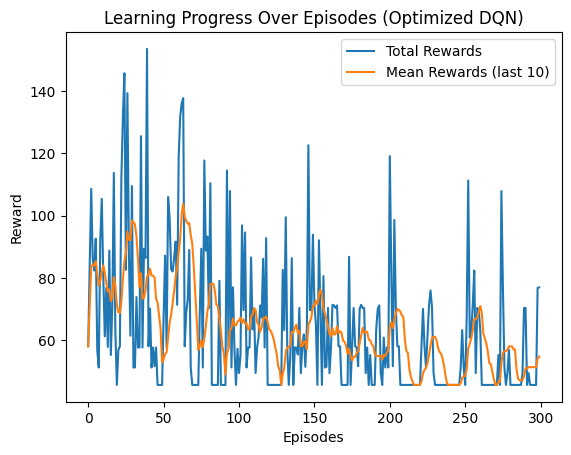

In [ ]:
i a    train_optimized_dqn_2()

**B. The network structure (4 marks).**




# **Model 1**
This model is a Deep-Q network designed to approximate quality values (Q-values) for each of the actions that the model can take at the current state of its environment.
Details of our model for runnig through ALE/Pong-V5 goes as follows:
1. Input Layer
   Shape: (84, 84, 4) - This is a stack of 4 preprocessed frames which are resized to 84x84 pixels. It captures the temporal state of the game state. This enables the model to account for otion dynamics by providing sequential frames
2. Convolutional Layers -  These are layers that would extract spatial and temporal feature when you are stacking the frame inputs , these layers would detect low-level spatial patterns (edges and textures of the graphics of the game), Learn more complex spaital features from the first layer information and to eventually capture the detailed spatial features and thier relationships between each other

  First Layer:
  *   Filters: 32
  *   Kernel Size: 8 x 8
  *   Strides: 4
  *   Activation: ReLU
  *   Output Shape: (20, 20, 32)

  Second Layer:
  *   Filters: 64
  *   Kernel Size: 4×4
  *   Strides: 2
  *   Activation: ReLU
  *   Output Shape: (9, 9, 64)

  Third Layer:
  * Filters: 64
  * Kernel Size: 3x3
  * Strides: 1
  * Activation: ReLU
  * Output Shape: (7, 7, 64)

3. Flatten Layer - This Flattens the 3D map that has been captured within the output of the convolutional layers into a 1 Dimensional vector which will be more suitable for connected layers. (An output from the third layer would be 3136, as we multiply all of the numbers stored as the values of it's output shape)

4. Fully Connected Layers - These get the exctracted features from the layers and input them into Q-Values , makes a representation of the flattened values which would shine a light on the previous input values and would then output a Q_value for each action taken.

  First Dense Layer:
    * Units: 512
    * Activation: ReLU
  Second Dense Layer:
    * Units: Equal to **action_space**
    * Activation: Linear (This makes sure Q-Values are unbounded)

5. Compilation - We use the Adam optimiser with a learning rate 1x10^-5 and we use a loss function with as Mean Squared Error which minimises the error between predicted Q-Values and their targets during training of the model.
# **Model 2**

Input layer: Accepts the state input (84,84,4). Frames are stacked to give the agent a sense of motion.

**First Convolutional Layer:** The kernel (8x8) and stride (4) allow the agent to quickly capture the big picture. This layer extracts coarse features (ball, paddles etc.)  

**Residual Block 1:** 64 Filters. The Kernel (4x4) is reduced in size as the agent's smaller kernels improve extracting detailed interactions (ball hits the paddle)  

**Residual Block 2:** Smaller kernel and stride to understand features

**Flatten Layer:** Converts 3D feature maps into a 1D vector of fully connected layers. This allows the agent to interpret features before a decision is made.

**State-Value Stream:** Estimates how good it is to be in a particular state.  

**Combining State-Value and Advantage:** Combines State Value (How good the current situation is) and Advantage (How much better/worse an action is compared to the average action in the state). This helps the agent decide the best move.

**Output Layer:** Outputs Q value for each action.  The agent selects the action with the highest Q-value to maximize future rewards (e.g., scoring points).



# **Why is Model 2 better than Model one:**

**Handles Complexity:**

The residual blocks efficiently extract features from the input frames, helping the agent understand ball-paddle interactions and wall bounces.

**Encourages Exploration:**

The dueling architecture separates state value and action advantages, ensuring the agent explores actions even in good states (e.g., deciding how to intercept the ball).

**Stabilizes Training:**

Residual connections prevent performance degradation in deeper networks.

Normalizing advantages in the dueling architecture mitigates overestimation of Q-values.


**C. A very clear and extremely detailed discussion on the code where the Q learning update applied to the weights (3 marks).**


Replay Buffer (Experience Replay)
The replay buffer stores transitions in the form of (state,action,reward,nextstate,done) to break correlations between consecutive samples and allow the agent to learn from diverse past experiences.
agent.remember(state_stack, action, reward, next_state_stack, done)
The remember function appends the transition to the replay buffer.

Sampling a Mini-Batch
The agent.replay() function samples a mini-batch of transitions from the replay buffer for training. This ensures the agent learns from a diverse set of experiences rather than relying solely on recent transitions.
batch = random.sample(replay_buffer, batch_size)

Q-Value Prediction
For each transition in the batch, the Q-network predicts the Q-values for the current state:
q_values = model.predict(state_stack)
current_q_value = q_values[0][action]
This extracts the Q-value corresponding to the action taken during the transition.

Target Q-Value Computation
The target Q-value is computed based on whether the transition led to a terminal state or not:
For Non-Terminal States:
next_q_values = target_model.predict(next_state_stack)
max_next_q_value = np.max(next_q_values[0])
target_q_value = reward + gamma * max_next_q_value
For Terminal States:
if done:
    target_q_value = reward
This target Q-value incorporates the reward and the discounted future reward

Temporal Difference (TD) Error and Loss Computation
Temporal Difference (TD) Error: The TD error measures the difference between:
The current Q-value prediction predicted by the Q-network for the action taken in a given state.
The target Q-value represents the reward and the expected future discounted reward from the next state.
The Q agent uses a loss function of mean squared error (MSE) to:
  Minimise TD Error: By using the MSE loss, the agent gradually reduces the TD error over time, leading to more accurate Q-value predictions.
  Improve Policy: As the Q-values become more accurate, the agent gets better at selecting optimal actions, improving its overall policy.
td_error = target_q_value - current_q_value
loss = td_error**2
The loss function computes as:
loss = np.mean((target_q_values - predicted_q_values)**2)

Backpropagation and Weight Updates
Using the computed loss, the neural network updates its weights to reduce the TD error. This is done via backpropagation:
optimizer.zero_grad()
loss.backward()
optimizer.step()

Target Network Updates
The agent uses a target network to stabilize learning. The target network is updated less frequently:
if episode % 5 == 0:
    agent.update_target_model()
The update_target_model() function performs a hard copy of weights from the Q-network to the target network:
target_model.set_weights(model.get_weights())



**D. Independently researched concepts such as random seed initialisation, the impact of regularisers on scores, and techniques to counter catastrophic forgetting and maximisation bias (5 marks).**

Advantages of Regularization in RL:
The network can better handle unvisited states by not overfitting to specific visited states.
Regularization smooths Q-value updates, particularly in noisy environments.
Regularized networks are less sensitive to minor perturbations in state or action space.
Dropout:
Randomly disables a fraction of neurons during training, forcing the network to rely on multiple pathways.
Useful in deep networks with large capacities.
Reduces dependency on specific neurons, making the network more robust to variations in input states.
If dropout is too aggressive, it may slow down convergence or degrade performance.

Model 1(Regularizes on scores)

layers.Dropout(0.2): A dropout rate of 20% of the neurons will be randomly deactivated during each training iteration. This prevents the model from overfitting and becoming dependent on specific neurons  



Duelling Architecture
The duelling network architecture is a modification to the Q-network used in deep reinforcement learning. It improves the learning efficiency and stability by separately estimating the value of being in a state and the advantage of taking a specific action. The value of being in a state is prioritised over the value of the action. In certain states, like terminal or exploration states, the choice of action may not matter much
Advantages:
Reduces unnecessary updates to action Q-values when only the state value matters.
Separating the state value and the action value allows the network to learn the value of states even when actions have little effect.
The architecture generalizes better by focusing on the state value and fine-tuning the advantages of actions.
By decomposing Q-values, updates become more stable as the network can learn state values independently of action-specific noise.


Model 2 (Maximization Bias)

build_optimized_dqn_model uses the Dueling Network Architecture, which splits the Q-value calculation into two streams:  

State-Value Stream (The value of being in a position irrespective of actions)



value = layers.Dense(512, activation='relu')(x)

value = layers.Dense(1, activation='linear')(value)   





Advantage Stream (The value of taking a specific action in each state compared to the average action in a stage)



advantage = layers.Dense(512, activation='relu')(x)

advantage = layers.Dense(action_space, activation='linear')(advantage)



Subtracting the mean of A(s, a) ensures the network doesn’t favor actions and stabilises learning.

mean_advantage = layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage) q_values = layers.Add()([value, layers.Subtract()([advantage, mean_advantage])])

 Separating State Value and Action Advantages ensures that the agent doesn’t overestimate the importance of specific actions.


# 4. **Plots:**

For our plots we had already two that were made after we trained both the original and the optimised models.

Original: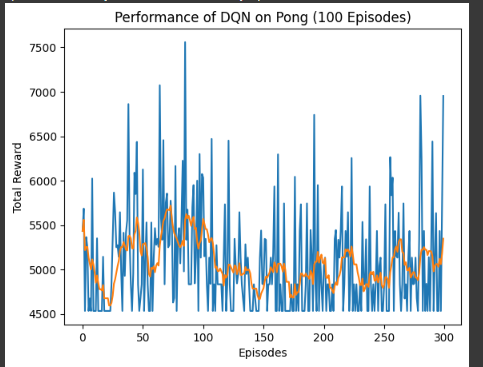

Optimised: 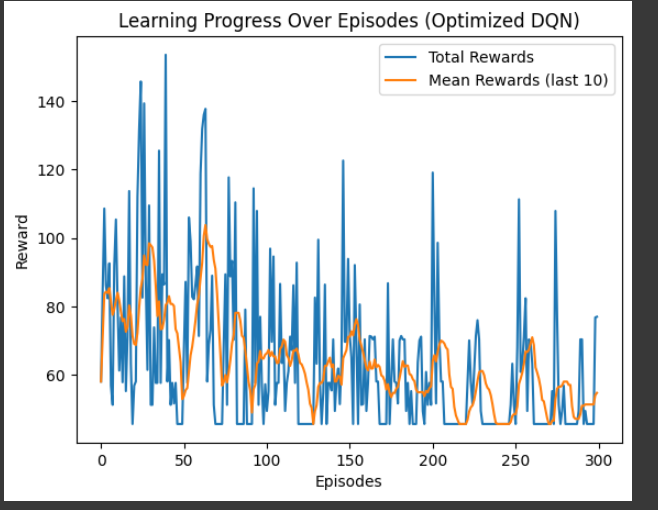

There's a clear contrast between the both of them, one being wildly more erratic than the other. The optimised shows that when it finds a strategy it sticks to it more rather than not than our original model but with both, we could not run them for long enough in terms of episodes to really give light to their training due to time constraints with the running of both the models

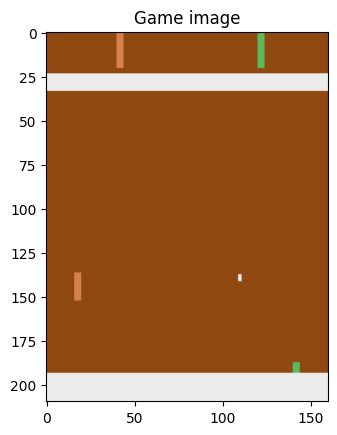

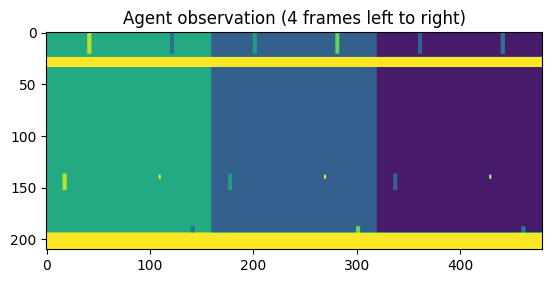

In [ ]:
for _ in range(50):
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())

plt.title("Game image")
plt.imshow(env.render())
plt.show()

state_dim = obs.shape
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));

# 5. **Videos and plots with short accompanying explanations of the information conveyed:**

In this code block we display a video of the evaluated model performing a singular game with the experience gained from it's training, utilizing it's weights that it has amassed from the rigorous procedures it went through.

Episode 1: Total Reward: -21.0


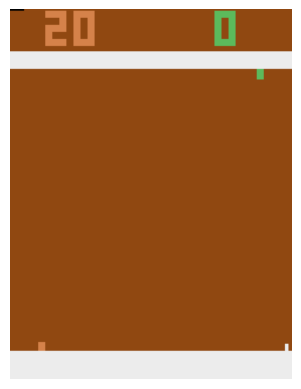

In [ ]:


def evaluate_agent(env, model_path, episodes=1, render=True):
    # Load the pre-trained model:
    model = tf.keras.models.load_model(model_path, custom_objects={'mse': tf.keras.losses.MeanSquaredError()})

    # Assuming DQNAgent is defined elsewhere in your code
    agent = DQNAgent(action_space=env.action_space.n)
    agent.model = model  # Assign the loaded model to the agent

    for episode in range(episodes):
        state, info = env.reset()
        state = preprocess_frame(state)
        state_stack = stack_frames(None, state, stack_size=4)
        state_stack = np.expand_dims(state_stack, axis=0)

        frames = []
        total_reward = 0
        done = False

        # Create rendering environment outside the loop:
        if render:
            env_render = gym.make('ALE/Pong-v5', render_mode="rgb_array")
            env_render.reset()  # Reset outside the loop

        while not done:
            action = np.argmax(agent.model.predict(state_stack, verbose=0)[0])

            # Step in the original environment for game logic:
            next_state, reward, done, truncated, info = env.step(action)

            # Step in the render environment to get the frame:
            if render:
                _, _, _, _, _ = env_render.step(action)  # Step for rendering
                frame = env_render.render()
                frames.append(frame)

            total_reward += reward
            if done or truncated:
                break

            next_state = preprocess_frame(next_state)
            next_state_stack = stack_frames(state_stack[0], next_state, stack_size=4)
            state_stack = np.expand_dims(next_state_stack, axis=0)

        print(f"Episode {episode + 1}: Total Reward: {total_reward}")
        if render:
            return frames


env = gym.make('ALE/Pong-v5')
model_path = 'pong_dqn_100_episodes.h5'
frames = evaluate_agent(env, model_path, episodes=1, render=True)

# Create a video from the frames
def display_video(frames):
    """
    Converts a list of frames into a video and displays it inline.
    """
    fig, ax = plt.subplots()
    ax.axis('off')
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=50, blit=True)
    return HTML(ani.to_jshtml())

# Show the gameplay
video = display_video(frames)
video


# 6. **Evaluation of the results:**

**A. How does one evaluate the performance of the RL agent?**

Monitor the number of Q Agent wins per episode over time to ensure that the win rate is increasing and that learning is occurring
Average time per game over time:
we should see the first games not last long as the Q Agent mostly loses
as the agent learns we should see the games last longer as it learns to take more steps towards winning
we would then expect the time per game to go down as the Q Agent improves
Number of wins per batch so that we can track whether/how much the Q Agent is improving

**B. Are the metrics that we have seen to date relevant?**
We believe the metrics are relevent but feel as though we need more training to show proof of learning, but struggled to train due to lack of resources.  

# 7. **References:**
https://cse.sc.edu/~aakriti/aakriti_files/RL_Pong_Final.pdf
https://medium.com/@kabila2022/mastering-atari-game-deep-q-network-dqn-agents-in-reinforcement-learning-7e1ac5448858


